# Masked Autoencoder for estimation 2D distribution

### 15.02.2022

In [10]:
import torch

import itertools
from PIL import Image
import io
import pickle
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Theoretical moments and understanding

### 1.1 Distribution estimation and Autoregressive models

В задаче оценивания плотностей перед нами стоит задача как имея

- Выборку объектов $\{x\}_{i=1}^{n}$
- Вероятностную модель $p_{\phi}(x)$, как пример параметризованную нейросетью

Приблизить распределение $p_{\phi}(x)$ к истинному распределению на данных $p_{true}(x)$

В качестве такой модели, параметризованной нейросетью, мы рассмотрим авторегрессионную модель, сначала пропишем известную формулу условной вероятности

$$ p(x,y,z) = p(x|y,z)p(y|z)p(z) \quad (1)$$

Тогда для большого количества переменных

$$ p(x) = p(x_{n}|x_{n-1},..,x_{1})...p(x_{2}|x_{1})p(x_{1}) = \prod_{d=1}^{D}p(x_{d}|x_{< d})  $$

Также запись данная в иностранной литературе именуется как Product rule 

$\textbf{Вопрос 1}$ Что такое $x_{<d}$ ? 



Ответ -   обозначение $x_{<d} = [x_{1} ,....,x_{d-1}]$


Предположим, мы рассматриваем бинарный многомерный вектор входов , где значение каждого элемента бинарное либо 0, либо 1. Тогда 
$$ p_{\phi}(x_{d} = 1 |x_{<d}) = \hat{x_{d}},\quad  p_{\phi}(x_{d} = 0|x_{<d}) = 1 - \hat{x_{d}}$$

$\textbf{Вопрос 2}$ Для решения на каком из известных датасетов можно рассматривать бинарную модель, а на каком нет? 


Ответ - Мнист

Для нашей модели мы бы хотели максимизировать правдоподобие $\log p(x)$ , ну или минимизировать негативный логарифм правдоподобия

$\textbf{Вопрос 3}$ Как выпишется негативный логарифм правдоподобия в постановке такой задачи?

$$ -\log p_{\phi}(x) = \sum_{d} - \log p_{\phi}(x_{d}|x_{<d}) = \sum_{d}^{D}(-x_{d}\log p_{\phi}(x_{d} = 1|x_{<d}) - (1 - x_{d}) \log p_{\phi}(x_{d}=0|x_{<d})) = l(x)$$

$\textbf{Вопрос 3.1}$ 

- В чем проблема такой оценки максимального правдоподобия с точки зрения статистики?
- Что можно сказать про несмещенность и состоятельность?

### 1.2 Masked Autoencoder

Прежде всего, проговорим наши хотелки 

- построить связную многослойную линейную модель
- падать на вход наш объект по-координатно
- на выход получить всевозможные вероятности вида

$$ p(x) = \prod_{d=1}^{D} p(x_{d}|x_{< d})$$

В нашем случае это вероятности вида следующего

- $p(x_{3}|x_{2},x_{1})$
- $p(x_{2}|x_{1})$
- $p(x_{1})$

Прежде всего, давайте введем следующее важное понятие как маскимальная входная размерность, обозначаемая буквой m в каждом слое. То есть, какая наибольшая координата (по возрастанию) входит в какой-то нейрон. Таким образом, если такое число равно 1 - это означает , что такая вершина в графе вычислений опирается пока только на $x_{1}$. Таким образом, опираясь на такие координаты мы всегда сможем посчитать вероятности $p(x_{2}|x_{1})$, и никогда не $p(x_{3}|x_{1},x_{2})$, так как никогда не обуславливалась на $x_{2}$.

Давайте обозначим, первоначальный массив как простое соответствие номеру координаты

In [110]:
m_0 = np.arange(1,4)
m_0

array([1, 2, 3])

Познакомимся со следующей визуализацией для понимания 

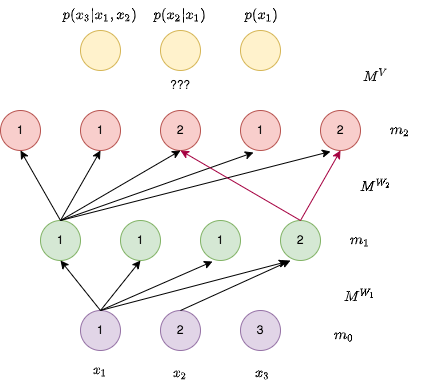

In [153]:
Image.open('mask.png')

Коль, нам нужна вероятность $p(x_{3}|x_{1},x_{2})$ - то логично, чтоб на вершину ,с максимальной входной размерностью равной 3, никто не опирался. Остается, вопрос как выбрать максимальную входную размерность для выходных нейронов первого слоя?

$$ m_{l} = \mathbf{U}  (\min_{k} m_{l-1}[k], \quad D-1)$$

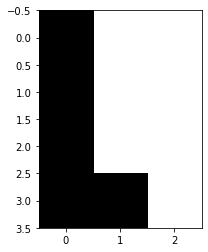

In [126]:
#m_1 = np.random.randint(m_0.min(),3,size=4)
m_1 = np.array([1.,1.,1.,2.])

mask =  m_0[:, None] <= m_1[None, :]
plt.imshow(mask.T,cmap="Greys");

В дальнейшем ситуация продолжается, мы 

- сначала семплируем из ранвомерного распределения список максимальных входных размерностей m
- на основе предыдущего и текущего списка - строим матрицу
- получаем линейный неполносвязный слой

$\textbf{Вопрос 4}$ 

- Расставьте чиселки на желтых кружочках
- Изобразите матрицу последнего линейного слоя

### 1.4 Creating torch linear models

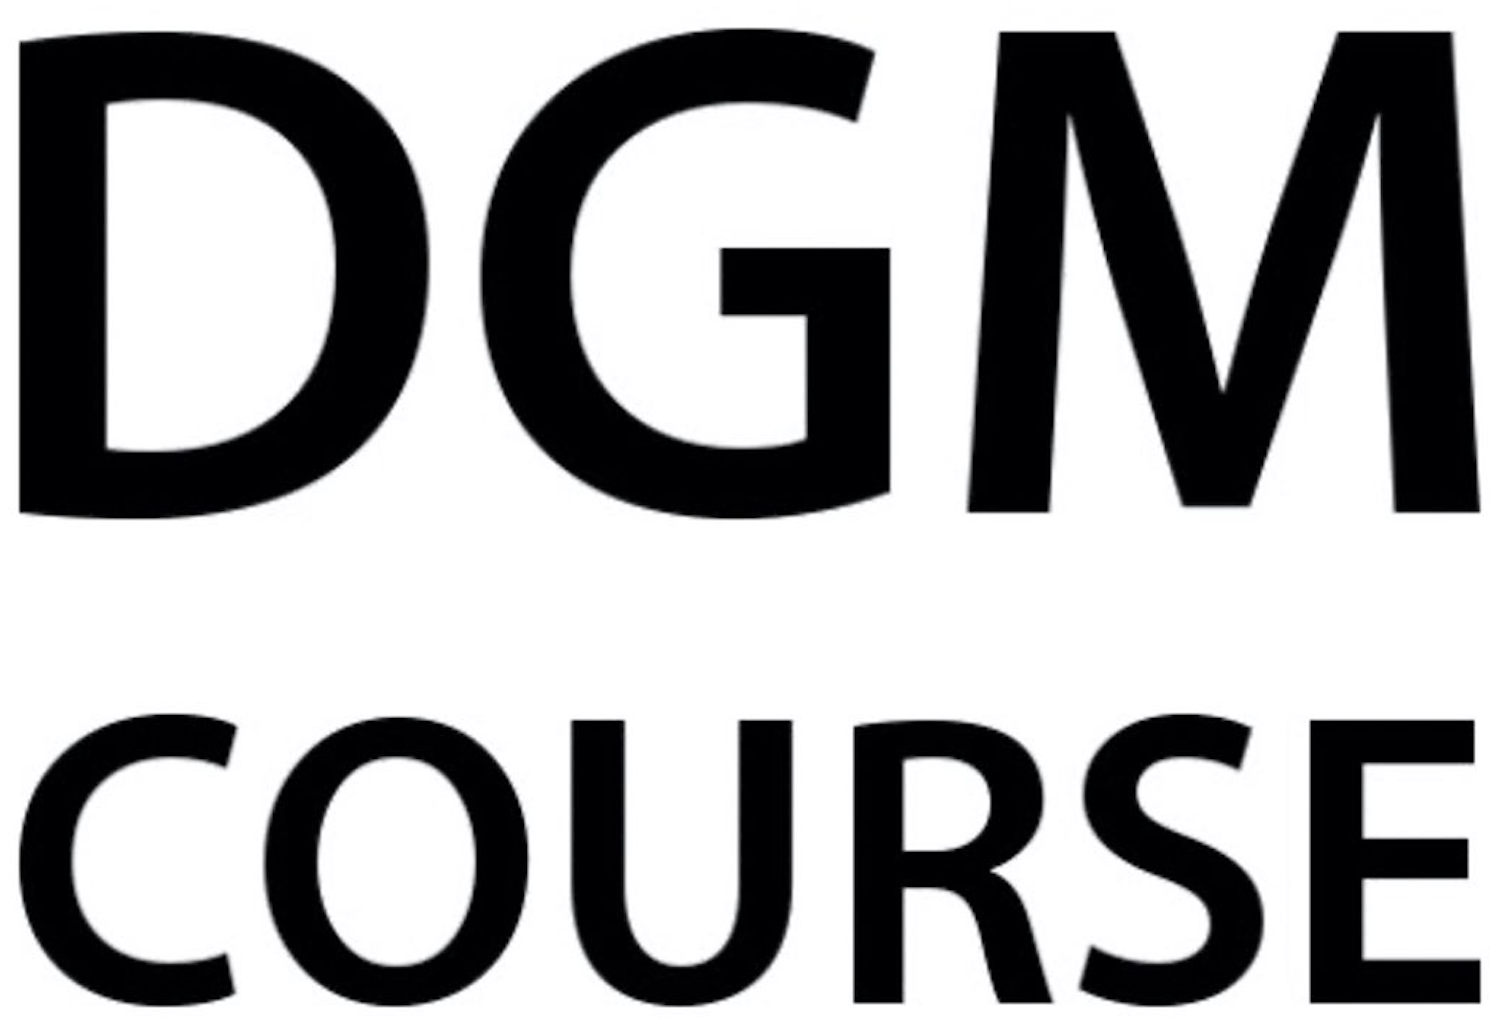

In [199]:
Image.open('dgm.png')

## 1. Generating 2D Data

In [57]:
def generate_2d_data(count, bins):
    
    # change the path to the image
    im = Image.open('dgm.png').resize((bins, bins)).convert('L')
    # values of im from 0 TO 256
    im = np.array(im).astype('float32')  
    dist = im / im.sum()
    # shape of: [bins , bins]
    
    # storage bin's coordinate (coordinate of one cell)
    pairs = list(itertools.product(range(bins), range(bins)))
    
    
    idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
    
    samples = np.array([pairs[i] for i in idxs])
    # shape of : [count, 2]  

    split = int(0.8 * len(samples))
    return dist, samples[:split], samples[split:]

In [58]:
def plot_2d_data(train_data, test_data):
    
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    ##print(bins) = 60
    
    train_dist, test_dist = np.zeros((bins, bins)), np.zeros((bins, bins))
    
    for i in range(len(train_data)):
        train_dist[train_data[i][0], train_data[i][1]] += 1
        
    train_dist /= train_dist.sum()

    for i in range(len(test_data)):
        test_dist[test_data[i][0], test_data[i][1]] += 1
    test_dist /= test_dist.sum()

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.set_title('Train Data')
    ax1.imshow(train_dist, cmap='gray')
    ax1.axis('off')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x0')

    ax2.set_title('Test Data')
    ax2.imshow(test_dist, cmap='gray')
    ax2.axis('off')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x0')

    plt.show()

In [59]:
def plot_2d_distribution(true_dist, learned_dist):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.imshow(true_dist, cmap='gray')
    ax1.set_title('True Distribution')
    ax1.axis('off')
    ax2.imshow(learned_dist, cmap='gray')
    ax2.set_title('Learned Distribution')
    ax2.axis('off')

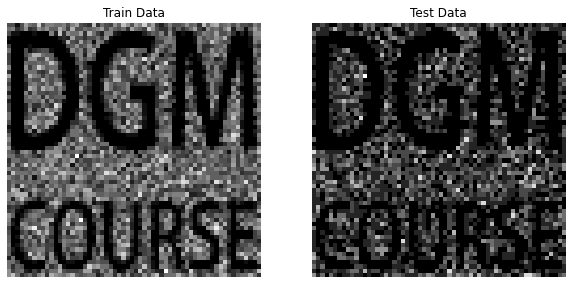

In [60]:
COUNT = 20000
BINS = 60

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data)

## 2. Problem statement

В данной задаче наш автоэнкодер будет принимать 2 точки, каждую из которых мы при помощи one_hot_encoding в вектор из 60 элементов, состоящий из 0 и 1, после этого склеив эти 2 вектора ,мы получаем вектор из 120 элементов. Данный вектор мы и будем подавать в автоэнкодер. Поскольку у нас автоэнкодер вернет тоже вектор из 120 элементов, то на выходе мы получаем какой-то 120-й элементный вектор. В классе MADE, мы в реализации учтем тот момент что величина m[idx] (номер максимального элемента с предыдущего слоя, который связан с данной вершиной в текущем слое) будет в прямом порядке от 0 до 1 как на входе, так и на выходе. (Ведь у нас с вами 2 точки) Таким образом, данный выходной вектор, тоже будет представлять собой вектор из двух вектора по 60 элементов, где первый это какой-то образ первой координаты, а второй вектор какой-то образ второй координаты. Поскольку нам нужна вероятность, то каждый из таких векторов мы прогоним через Softmax, и оба их склеим. Опять получим вектор из 120 элементов , где каждое значение от 0 до 1. И для того, чтобы определить вероятность данной пары мы воспользуемся следующей формулой из статьи:

In [179]:
class MaskedLinear(torch.nn.Linear):
    
    
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
         
        return torch.nn.functional.linear(input, self.mask * self.weight, self.bias)


$\textbf{Вопрос 5}$ В чем идея различных реализаций линейной модели ??

In [ ]:
# todo

In [180]:
layer = MaskedLinear(2, 2)

x = torch.tensor([1, 2], dtype=torch.float32)
output = layer(x).detach().numpy()

layer.set_mask(np.array([[0, 0], [0, 0]]))
assert np.allclose(layer(x).detach().numpy(), layer.bias.detach().numpy())

layer.set_mask(np.array([[1, 1], [1, 1]]))
assert np.allclose(layer(x).detach().numpy(), output)

In [181]:
def to_one_hot(labels, d):
    
    """
        The function takes categorical labels of size: batch_size x n_dims.
        One-hot encodes them to d bins and then reshapes the result to batch_size x (n_dims * d)
        
    """
    
    assert len(labels.shape) == 2
    one_hot = torch.nn.functional.one_hot(labels.to(torch.int64), d)
    return one_hot.view((labels.shape[0], -1)).float()

In [197]:
class MADE(torch.nn.Module):
    
    def __init__(self, nin, bins, hidden_sizes):
        
        super().__init__()
        
        
        self.nin = nin # 2
        self.nout = nin * bins # 120
        self.bins = bins # 60
        
        self.hidden_sizes = hidden_sizes
        # we will use the trivial ordering of input units
        self.ordering = np.arange(self.nin)

        
        # define a simple MLP (sequence of MaskedLinear and ReLU) neural net 
        # self.net = nn.Sequential(list of layers)
        # do not place ReLU at the end of the network!
        # note: the first layer of model should have nin * bins input units
        
        
        self.net = []
        hs = [self.nin * bins] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs[:-2], hs[1:-1]):
            self.net.extend([
                MaskedLinear(h0, h1),
                torch.nn.ReLU(),
            ])
            
        
        self.net.append(MaskedLinear(hs[-2], hs[-1]))
        self.net = torch.nn.Sequential(*self.net)
       

        self.create_mask()  # builds the initial self.m connectivity

 


    #----------------------------------------------------------#
    def create_mask(self):
        
        
        # 1) The ordering of input units from 1 to m (self.ordering).
        # 2) Assign the random number k from 1 to m − 1 to each hidden unit. 
        #    This number gives the maximum number of input units to which the unit can be connected.
        # 3) Each hidden unit with number k is connected with the previous layer units 
        #   which has the number is less or equal than k.
        # 4) Each output unit with number k is connected with the previous layer units 
        #    which has the number is less than k.

        
        self.m = {}
        self.masks = []
        L = len(self.hidden_sizes)
        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), 
                                      self.nin - 1, size=self.hidden_sizes[l]) # ?? nin
            
            
        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.bins, axis=1)  
        masks[0] = np.repeat(masks[0], self.bins, axis=0)
        
        self.masks = masks 
       

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    #----------------------------------------------------------#
    
    
    def visualize_masks(self):
        prod = self.masks[0]
        for idx, m in enumerate(self.masks):
            plt.figure(figsize=(3, 3))
            plt.title(f'layer: {idx}')
            plt.imshow(m, vmin=0, vmax=1, cmap='gray')
            plt.show()

            if idx > 0:
                prod=prod.dot(m)

        plt.figure(figsize=(3, 3))
        plt.title('prod')
        plt.imshow(prod, vmin=0, vmax=1, cmap='gray')
        plt.show()

    #-----------------------------------------------------------#   
    
    def forward(self, x):
        
        """
        
        x - torch.Size([B,2])
        
        
        """
        
        assert len(x.size()) == 2
        assert x.shape[1] == self.nin
        batch_size = x.shape[0]
     
        # 1) apply one hot encoding to x
        # 2) apply the model
        # 3) reshape and transpose the output to (batch_size, self.bins, self.nin)
        
        
        x = to_one_hot(x, self.bins) 
        # torch.tensor([B,120])
        
        logits = self.net(x)
        # torch.tensor ([B,120])
        
        logits = logits.view(batch_size, self.nin, self.bins)
        # torch.tensor([B,2,60])
        
        return logits.permute(0, 2, 1).contiguous()
    
    
      
    #------------------------------------------------------------#
    
    def sample(self, n, use_cuda=False):
        # read carefully and understand the sampling process
        xs = []
        for _ in range(n):
            x = torch.randint(0, self.bins, (1, self.nin))
          
            for it in range(self.nin):
                probs = torch.nn.functional.softmax(model(x)[0], dim=0).T
                distr = torch.distributions.categorical.Categorical(probs)
                x[0, it] = distr.sample()[it]
            xs.append(x)
        xs = torch.cat(xs)
        return xs.cpu().numpy()
    
    

### 4. Train fucntions

In [183]:
def get_cross_entropy_loss(scores, labels):
    # ====
    # your code
    return torch.nn.functional.cross_entropy(scores, labels.long())
    # ====


def test_get_cross_entropy_loss():
    input = torch.tensor([[1, 2, 3, 4],[5, 6, 7, 8]], dtype=torch.float32)
    target = torch.tensor([3, 1], dtype=torch.long)

    assert np.allclose(get_cross_entropy_loss(input, target).numpy(), 1.4402)

test_get_cross_entropy_loss()

In [184]:
def train_epoch(model, train_loader, optimizer, use_cuda):
    model.train()
  
    train_losses = []
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        loss = get_cross_entropy_loss(model(x), x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_model(model, data_loader, use_cuda):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            loss = get_cross_entropy_loss(model(x), x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_model(model, train_loader, test_loader, epochs, lr, use_tqdm=False, use_cuda=False):
    if use_cuda:
        model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_model(model, test_loader, use_cuda)]
    if use_tqdm:
        forrange = tqdm(range(epochs))
    else:
        forrange = range(epochs)
    for epoch in forrange:
        model.train()
        train_losses.extend(train_epoch(model, train_loader, optimizer, use_cuda))
        test_loss = eval_model(model, test_loader, use_cuda)
        test_losses.append(test_loss)

    return train_losses, test_losses


def plot_training_curves(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title('training curves')
    plt.xlabel('Epoch')
    plt.ylabel('NLL')

## 4.Hyperparameters

In [186]:
HIDDEN_SIZES = [100, 100, 100]
 

model = MADE(2, BINS, HIDDEN_SIZES)


def test_model_output(model):
    assert [10, BINS, 2] == list(model(torch.randint(0, BINS, (10, 2))).size())


def test_create_mask(model):
    prod = np.ones((1, BINS * 2))
    for m in model.masks:
        assert set(np.unique(m)).issubset((True, False))
        prod = prod.dot(m)
    assert np.allclose(prod, np.repeat(np.array([[0, BINS * np.prod(HIDDEN_SIZES)]]), BINS))

test_create_mask(model)
test_model_output(model)

In [187]:
BATCH_SIZE = 1024
EPOCHS = 20
LR = 1e-3
USE_CUDA = False

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=USE_CUDA)

assert test_losses[-1] < 4.0

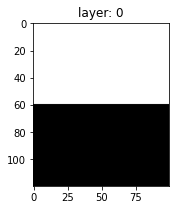

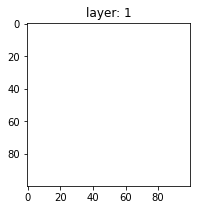

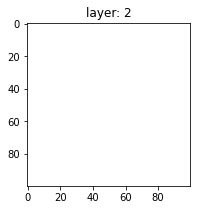

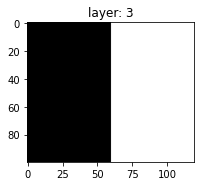

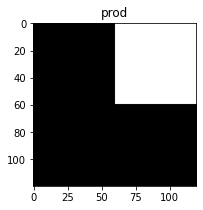

In [188]:
model.visualize_masks()

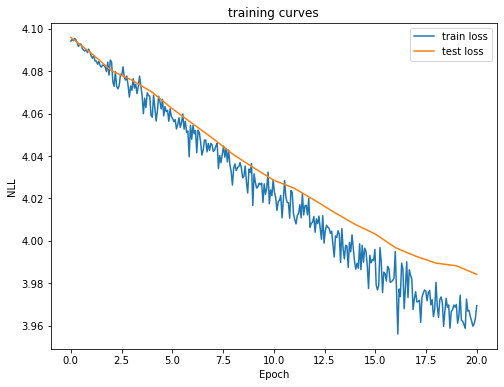

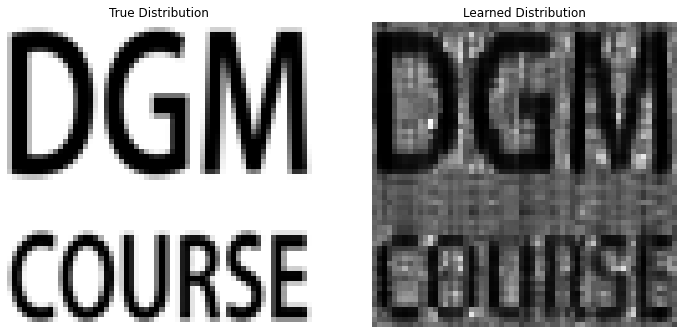

In [195]:
def get_distribution(model, use_cuda=False):
    x = np.mgrid[0:model.bins, 0:model.bins].reshape(2, model.bins ** 2).T
    # ====
    # your code
    # 1) take the model output for the grid x (shape: bins ** 2, bins, 2)
    # 3) apply log_softmax to get log probs (shape: bins ** 2, bins, 2)
    # 4) apply torch.gather to gather vaalues indexed by grid x (shape: bins ** 2, 2)
    # 5) sum the log probs over dim=1 (shape: bins ** 2)
    # 6) exponentiate it (shape: bins ** 2)
    # 7) return an array BINS x BINS with probabilities of each pixel

    x = torch.LongTensor(x)
    
    log_probs = torch.nn.functional.log_softmax(model(x), dim=1)
    distribution = torch.gather(log_probs, dim=1, index=x.unsqueeze(1)).squeeze(1) 
    distribution = distribution.sum(dim=1)
    return distribution.exp().view(model.bins, model.bins).detach().cpu().numpy()
    # ====


distribution = get_distribution(model,USE_CUDA)
assert distribution.shape == (BINS, BINS)

plot_training_curves(train_losses, test_losses)
plot_2d_distribution(image, distribution)